# Imports

## Python Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn.functional as F

from copy import deepcopy
from datetime import datetime
import json 
from PIL import Image
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models



/home/ibs/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-06-12 21:41:11.215035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 21:41:11.989096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Importing the datasets

In [2]:
dataset = pd.read_csv('Datasets/Products.csv', lineterminator='\n')

# Cleaning the Dataset

## Cleaning the table

In [3]:
dataset.count(), dataset.dropna().count(), dataset["price"].map(lambda x: x[0]).unique(), dataset["price"].map(lambda x: x[-3:]).unique()

(Unnamed: 0             7156
 id                     7156
 product_name           7156
 category               7156
 product_description    7156
 price                  7156
 location               7156
 dtype: int64,
 Unnamed: 0             7156
 id                     7156
 product_name           7156
 category               7156
 product_description    7156
 price                  7156
 location               7156
 dtype: int64,
 array(['£'], dtype=object),
 array(['.00', '.99', '.78', '.01', '.97', '.25', '.50', '.20', '.90',
        '.80', '.60', '.23', '.05', '.75', '.56', '.40', '.44', '.95',
        '.66', '.35', '.85', '.30', '.45', '.16', '.69', '.49', '.55',
        '.09', '.11'], dtype=object))

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7156 entries, 0 to 7155
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           7156 non-null   int64 
 1   id                   7156 non-null   object
 2   product_name         7156 non-null   object
 3   category             7156 non-null   object
 4   product_description  7156 non-null   object
 5   price                7156 non-null   object
 6   location             7156 non-null   object
dtypes: int64(1), object(6)
memory usage: 391.5+ KB


# So the dataset seems to already be clean

Now we convert the price column

In [5]:
dataset_cleaned = dataset

def remove_pound_sign(string_to_replace) -> str:
    return 

dataset_cleaned['price'] = dataset_cleaned['price'].map(lambda x : x.replace('£', '')) #Removes the pound signs
dataset_cleaned['price'] = dataset_cleaned['price'].map(lambda x: x.replace(',', '')) #Removes commas

dataset_cleaned['price'] = pd.to_numeric(dataset_cleaned['price'])

# Now we extract the root category from each item

In [6]:
dataset_cleaned['category'] = dataset_cleaned['category'].map(lambda x: x.split(' /' )[0])

In [7]:
dataset_cleaned['category'].unique()

array(['Home & Garden', 'Baby & Kids Stuff', 'DIY Tools & Materials',
       'Music, Films, Books & Games', 'Phones, Mobile Phones & Telecoms',
       'Clothes, Footwear & Accessories', 'Other Goods',
       'Health & Beauty', 'Sports, Leisure & Travel', 'Appliances',
       'Computers & Software', 'Office Furniture & Equipment',
       'Video Games & Consoles'], dtype=object)

Now we create an encoder to go to and from the categories and integers

In [8]:
list_of_categories = list(dataset_cleaned['category'].unique())

encoder = {x: list_of_categories.index(x) for x in list_of_categories}

decoder = {list_of_categories.index(x):x for x in list_of_categories}

encoder, decoder

#Let's save these to pickle files:

with open("encoder_pickle", 'wb') as encody:
    pickle.dump(encoder, encody)

with open("decoder_pickle", 'wb') as decody:
    pickle.dump(decoder, decody)

# Now we merge this with the original table:

In [9]:
dataset_cleaned['root_category'] = dataset_cleaned['category']
dataset_cleaned['root_category_index'] = dataset_cleaned['category'].map(lambda x:encoder[x])

# Next we merge this with the images table:

In [10]:
images_dataset = pd.read_csv('Datasets/Images.csv')

dataset_cleaned["merge_column"] = dataset_cleaned['id']
images_dataset['merge_column'] = images_dataset['product_id']

dataset_cleaned.dtypes, images_dataset.dtypes

(Unnamed: 0               int64
 id                      object
 product_name            object
 category                object
 product_description     object
 price                  float64
 location                object
 root_category           object
 root_category_index      int64
 merge_column            object
 dtype: object,
 Unnamed: 0       int64
 id              object
 product_id      object
 merge_column    object
 dtype: object)

In [11]:
merged_df = images_dataset.merge(dataset_cleaned, on='merge_column')

In [12]:
merged_df = merged_df[["id_x", "product_id", "root_category", "root_category_index"]]
merged_df = merged_df.rename(columns={'id_x':'id'})
merged_df = merged_df.drop(columns=['product_id'])

merged_df.dtypes

id                     object
root_category          object
root_category_index     int64
dtype: object

In [13]:
merged_df.to_csv('Datasets/training_data.csv', index=False)

## Clean Image Dataset:

In [14]:
def resize_image(final_size, im):
    size = im.size
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im = im.resize(new_image_size)
    new_im = Image.new("RGB", (final_size, final_size))
    new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    return new_im

def clean_images(path_to_extract = "Datasets/images/", path_to_save = "Datasets/cleaned_images/", image_size = 64):
    dirs = os.listdir(path_to_extract)
    final_size = image_size
    for n, item in enumerate(dirs, 1):
        #print(n, item)
        im = Image.open(path_to_extract + item)
        #print(im.width, im.height)
        new_im = resize_image(final_size, im)
        #print(new_im.width, new_im.height)
        new_im.save(path_to_save + item)


In [15]:
#clean_images(path_to_save="Datasets/cleaned_images_64/")

# Working with the Model

## Casting into a PyTorch dataset

In [26]:
class ImageDataset(Dataset):
    def __init__(self, df_of_keys:pd.DataFrame, folder_of_images:str) -> None:
        super().__init__()

        # Set the labels to be the column 'root_cotegory_index' of df_of_keys
        self.labels = df_of_keys['root_category_index']

        # Assings image_paths to the file name from the column 'id' of df_of_keys and maps it to it's path relative to the project root folder
        self.image_paths = df_of_keys['id'].map(lambda x : folder_of_images + x + '.jpg')

        # The Resent50 documentation said these transforms must be applied to the images before the model processes them
        self.image_transformer = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=45),
            transforms.PILToTensor(),
        ])
    
    def __getitem__(self, index):
        
        # Opens the image at index with using PIL.Image
        with Image.open(self.image_paths[index]) as img:

            # Sets the feature to be a tensor obtained by applying PILToTensor to the relevant image
            X = self.image_transformer(img)
        
        # y is the label from self.labels
        y = self.labels[index]

        #print(X.shape, y.shape)
        return X, y
    
    def __len__(self):
        return len(self.labels)



In [44]:
my_dataset = ImageDataset(merged_df, "Datasets/cleaned_images_64/")

# A quick sanity check of the dataset:
my_dataset[1][0], my_dataset[1][1].shape, len(my_dataset)

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 (),
 12604)

## Splitting the dataset:

In [45]:
train_dataset, test_dataset = torch.utils.data.random_split(
    my_dataset, [10000, len(my_dataset) - 10000],
)

train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset, [8000, 2000]
)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=True)

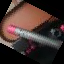

In [49]:
thing = transforms.ToPILImage()

thing(train_dataset[5][0].squeeze(0))


## Defining the model

In [50]:
# Sets the device for PyTorch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Loads the resnet50 model
#resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', model = 'nvidia_resnet50', pretrained = True )
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
# Don't know what this does
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
# Again don't know what this does
resnet50.eval().to(device)

torch.cuda.is_available(), device

Using cache found in /home/ibs/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


(True, device(type='cuda'))

## Examining the model

Let's print out the layers of resnet50:

In [51]:
for name, module in resnet50.named_parameters():
    if any(sub_string in name for sub_string in ['resnet50.layer4.2', 'resnet50.fc' ]):
        print(name, module.requires_grad)
    else:
        print(name, module.requires_grad)

conv1.weight True
bn1.weight True
bn1.bias True
layer1.0.conv1.weight True
layer1.0.bn1.weight True
layer1.0.bn1.bias True
layer1.0.conv2.weight True
layer1.0.bn2.weight True
layer1.0.bn2.bias True
layer1.0.conv3.weight True
layer1.0.bn3.weight True
layer1.0.bn3.bias True
layer1.0.downsample.0.weight True
layer1.0.downsample.1.weight True
layer1.0.downsample.1.bias True
layer1.1.conv1.weight True
layer1.1.bn1.weight True
layer1.1.bn1.bias True
layer1.1.conv2.weight True
layer1.1.bn2.weight True
layer1.1.bn2.bias True
layer1.1.conv3.weight True
layer1.1.bn3.weight True
layer1.1.bn3.bias True
layer1.2.conv1.weight True
layer1.2.bn1.weight True
layer1.2.bn1.bias True
layer1.2.conv2.weight True
layer1.2.bn2.weight True
layer1.2.bn2.bias True
layer1.2.conv3.weight True
layer1.2.bn3.weight True
layer1.2.bn3.bias True
layer2.0.conv1.weight True
layer2.0.bn1.weight True
layer2.0.bn1.bias True
layer2.0.conv2.weight True
layer2.0.bn2.weight True
layer2.0.bn2.bias True
layer2.0.conv3.weight True


- The final layer, `fc` takes in 2048 features and outputs 1000 features. The number of labels we need to classify, i.e. the number of distinct values in `merged_df['root_categories']` is 13.

- So we need to modify the `fc` layer so that it has 13 outputs. We do this by changing `fc` to `torch.nn.Linear(2048, 13)`.

In [52]:
class ImageClassifier(torch.nn.Module):
    def __init__(self, num_labels:int) -> None:
        super().__init__()
        self.resnet50 = models.resnet50(weights='IMAGENET1K_V1')
        
        # Freeze all the layers, by setting 'requires_grad = False'
        for param in self.resnet50.parameters():
            param.requires_grad = False
            pass
        
        # Unfreeze the final layer, by setting 'requires_grad = False' for the fc layer
        
        for name, module in self.named_parameters():
            if any(sub_string in name for sub_string in ['resnet50.layer4', 'resnet50.fc' ]):
                module.requires_grad = True
                print(name, module.requires_grad)
        

        self.final = torch.nn.Sequential(
            torch.nn.Dropout(),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 500),
            torch.nn.Dropout(),
            torch.nn.ReLU(),
            torch.nn.Linear(500, num_labels)
        )

    def forward(self, X):
        X = X.float()
        X = self.resnet50(X)
        X = self.final(X)
        X = F.softmax(X, dim=1)
        return X

In [53]:
model = ImageClassifier(13)

#print(model(my_dataset[0][0].unsqueeze(0)))

model.cuda()

for name, module in model.named_parameters():
    if any(sub_string in name for sub_string in ['resnet50.layer4.2', 'resnet50.fc' ]):
        print(name, module.requires_grad)
    else:
        print('Here', name, module.requires_grad)

resnet50.layer4.0.conv1.weight True
resnet50.layer4.0.bn1.weight True
resnet50.layer4.0.bn1.bias True
resnet50.layer4.0.conv2.weight True
resnet50.layer4.0.bn2.weight True
resnet50.layer4.0.bn2.bias True
resnet50.layer4.0.conv3.weight True
resnet50.layer4.0.bn3.weight True
resnet50.layer4.0.bn3.bias True
resnet50.layer4.0.downsample.0.weight True
resnet50.layer4.0.downsample.1.weight True
resnet50.layer4.0.downsample.1.bias True
resnet50.layer4.1.conv1.weight True
resnet50.layer4.1.bn1.weight True
resnet50.layer4.1.bn1.bias True
resnet50.layer4.1.conv2.weight True
resnet50.layer4.1.bn2.weight True
resnet50.layer4.1.bn2.bias True
resnet50.layer4.1.conv3.weight True
resnet50.layer4.1.bn3.weight True
resnet50.layer4.1.bn3.bias True
resnet50.layer4.2.conv1.weight True
resnet50.layer4.2.bn1.weight True
resnet50.layer4.2.bn1.bias True
resnet50.layer4.2.conv2.weight True
resnet50.layer4.2.bn2.weight True
resnet50.layer4.2.bn2.bias True
resnet50.layer4.2.conv3.weight True
resnet50.layer4.2.bn3

In [54]:
# The training loop. Takes in a model, the training and validation data loaders, the number of epochs and the initial learning rate
def train(model, train_loader, validation_loader, epochs = 10, learning_rate = 1):
    torch.cuda.memory_summary(device=device, abbreviated=False)

    torch.cuda.empty_cache()

    # Set the optimiser to be an instance of the stochastic gradient descent class
    # Only want the parameters in fc to be updated
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Define a learning rate scheduler as an instance of the ReduceLROnPlateau class
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', patience=50, cooldown=30, )

    # Writer will be used to track model performance with TensorBoard
    writer = SummaryWriter()

    # Keep track of the number of batches to plot model performace against
    batch_index = 0
    
    # Prints an validation score
    print(f"Initial validation accuracy score{accuracy_score_from_valiadation(model, validation_loader)}")

    #Create a dictionary to store the best model parameters
    best_model_parameters = {'Epoch':-1, 'Accuracy':0, 'Parameters':model.state_dict()}

    # Loop over the number of epochs
    for epoch in range(epochs):

        # Within each epoch, we pass through the entire training data in batches indexed by batch
        for batch in train_loader:
            # Loads features and labels into device for performance improvements
            features, labels = batch

            features = features.to(device)
            labels = labels.to(device)

            # Calculate the loss via cross_entropy
            loss = F.cross_entropy(model(features), labels)

            # Create the grad attributes
            loss.backward() 

            # Print the performance
            print(f"Epoch: {epoch}, batch index: {batch_index}, learning rate: {scheduler.get_last_lr()}, loss:{loss.item()}")

            # Perform one step of stochastic gradient descent
            optimiser.step()

            # Zero the gradients (Apparently set_to_none=True imporves performace)
            optimiser.zero_grad(set_to_none=True)

            # Feed the loss amount into the learning rate scheduler to decide the next learning rate
            scheduler.step(loss.item())

            # Write the performance to the TensorBoard plot
            writer.add_scalar('loss', loss.item(), batch_index)

            # Increment the batch index
            batch_index += 1
        
        # Print the validation loss
        accuracy = accuracy_score_from_valiadation(model, validation_loader)
        print(f"Epoch {epoch}, validation accuracy score{accuracy}")

        # Check if the model has the best perfomrance and save the parameters to 'best_model.pt'
        if accuracy > best_model_parameters['Accuracy']:
            best_model_parameters['Epoch'] = epoch
            best_model_parameters['Accuracy'] = loss.item()
            best_model_parameters['Parameters'] = model.state_dict()
            torch.save(model.state_dict(), 'model_evaluation/weights/best_model.pt')

        if epoch % 50 == 0:
            print(epoch % 50)
            # Create an instance of the datetime class
            dt = datetime.now()
            date_stamp = str(dt).replace(':', '_').replace('.', '_').replace(' ', '_')

            # Save the model parameters to the folder 'model_evaluation/weights', along with the time and epoch they were generated
            torch.save(model.state_dict(), f'model_evaluation/weights/model_{date_stamp}_epoch_{epoch}_accuracy_{accuracy}.pt') # Is there a better way to do this?

def accuracy_score_from_valiadation(model, validation_loader):
    validation_data = next(iter(validation_loader))

    features, labels = validation_data

    features = features.to(device)
    labels = labels

    predictions = [torch.argmax(prediction).cpu() for prediction in model(features)]

    #predictions.to('cpu')
    return accuracy_score(predictions, labels)


In [55]:
# Train the model
train(model, train_loader, validation_loader, epochs=500, learning_rate=1)

Initial validation accuracy score0.0703125


/home/ibs/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, batch index: 0, learning rate: [1], loss:2.5718727111816406
Epoch: 0, batch index: 1, learning rate: [1], loss:2.564833402633667
Epoch: 0, batch index: 2, learning rate: [1], loss:2.5673069953918457
Epoch: 0, batch index: 3, learning rate: [1], loss:2.5496344566345215
Epoch: 0, batch index: 4, learning rate: [1], loss:2.530001640319824
Epoch: 0, batch index: 5, learning rate: [1], loss:2.5343739986419678
Epoch: 0, batch index: 6, learning rate: [1], loss:2.5364067554473877
Epoch: 0, batch index: 7, learning rate: [1], loss:2.525616407394409
Epoch: 0, batch index: 8, learning rate: [1], loss:2.5332541465759277
Epoch: 0, batch index: 9, learning rate: [1], loss:2.510932207107544
Epoch: 0, batch index: 10, learning rate: [1], loss:2.51045560836792
Epoch: 0, batch index: 11, learning rate: [1], loss:2.549928903579712
Epoch: 0, batch index: 12, learning rate: [1], loss:2.5228328704833984
Epoch: 0, batch index: 13, learning rate: [1], loss:2.517366647720337
Epoch: 0, batch index: 1

KeyboardInterrupt: 

# Proof of concept, with just two labels

In [56]:
small_df = merged_df[1000:2000]

small_df['root_category']

small_df.reset_index(inplace=True)

small_dataset = ImageDataset(small_df, "Datasets/cleaned_images_224/")

small_train, small_valid = torch.utils.data.random_split(
    small_dataset, [800, 200]
)

small_train_loader = DataLoader(small_train, batch_size=150, shuffle=True, num_workers=4)
small_validation_loader = DataLoader(small_valid, batch_size=50, shuffle=True)

small_model = ImageClassifier(2)

small_model.cuda()

small_df

resnet50.layer4.0.conv1.weight True
resnet50.layer4.0.bn1.weight True
resnet50.layer4.0.bn1.bias True
resnet50.layer4.0.conv2.weight True
resnet50.layer4.0.bn2.weight True
resnet50.layer4.0.bn2.bias True
resnet50.layer4.0.conv3.weight True
resnet50.layer4.0.bn3.weight True
resnet50.layer4.0.bn3.bias True
resnet50.layer4.0.downsample.0.weight True
resnet50.layer4.0.downsample.1.weight True
resnet50.layer4.0.downsample.1.bias True
resnet50.layer4.1.conv1.weight True
resnet50.layer4.1.bn1.weight True
resnet50.layer4.1.bn1.bias True
resnet50.layer4.1.conv2.weight True
resnet50.layer4.1.bn2.weight True
resnet50.layer4.1.bn2.bias True
resnet50.layer4.1.conv3.weight True
resnet50.layer4.1.bn3.weight True
resnet50.layer4.1.bn3.bias True
resnet50.layer4.2.conv1.weight True
resnet50.layer4.2.bn1.weight True
resnet50.layer4.2.bn1.bias True
resnet50.layer4.2.conv2.weight True
resnet50.layer4.2.bn2.weight True
resnet50.layer4.2.bn2.bias True
resnet50.layer4.2.conv3.weight True
resnet50.layer4.2.bn3

,index,id,root_category,root_category_index
0,1000,47c3e7cf-9996-4e73-a0b4-8b7fb4ca5d0e,Home & Garden,0
1,1001,e07140ff-9bb9-4fc4-b156-13335159bbfb,Home & Garden,0
2,1002,646c85b0-8ea8-4904-b234-8fbf55d8e1ed,Home & Garden,0
3,1003,c65bf600-a038-4ce2-be43-a1867a4be5ec,Home & Garden,0
4,1004,29f4c193-47ba-41b0-89e6-bdfba5938d86,Home & Garden,0
...,...,...,...,...
995,1995,be6eb99e-e9ee-4974-9d95-4e369c59e665,Baby & Kids Stuff,1
996,1996,ab439d5f-529c-4ac3-a0b9-4e74ee2b65e7,Baby & Kids Stuff,1
997,1997,00ae22cf-1298-4a11-b416-15c2be484816,Baby & Kids Stuff,1
998,1998,108dd408-b1ba-42b1-b90d-599bc61e2e00,Baby & Kids Stuff,1


In [57]:
train(small_model, small_train_loader, small_validation_loader, epochs=30, learning_rate=0.01)

Initial validation accuracy score0.58


/home/ibs/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0, batch index: 0, learning rate: [0.01], loss:0.7139397859573364
Epoch: 0, batch index: 1, learning rate: [0.01], loss:0.721604585647583
Epoch: 0, batch index: 2, learning rate: [0.01], loss:0.7015841007232666
Epoch: 0, batch index: 3, learning rate: [0.01], loss:0.7155447006225586
Epoch: 0, batch index: 4, learning rate: [0.01], loss:0.7009787559509277
Epoch: 0, batch index: 5, learning rate: [0.01], loss:0.6873529553413391
Epoch 0, validation accuracy score0.5
0
Epoch: 1, batch index: 6, learning rate: [0.01], loss:0.6977428793907166
Epoch: 1, batch index: 7, learning rate: [0.01], loss:0.6752026677131653
Epoch: 1, batch index: 8, learning rate: [0.01], loss:0.7035495638847351
Epoch: 1, batch index: 9, learning rate: [0.01], loss:0.68355792760849
Epoch: 1, batch index: 10, learning rate: [0.01], loss:0.7017321586608887
Epoch: 1, batch index: 11, learning rate: [0.01], loss:0.7194548845291138
Epoch 1, validation accuracy score0.62
Epoch: 2, batch index: 12, learning rate: [0.0

# Feature extraction model

In [25]:
feature_extraction_model = deepcopy(model)

feature_extraction_model

feature_extraction_model.resnet50.fc = torch.nn.Identity()

torch.save(feature_extraction_model.state_dict(), 'model_evaluation/final_model/image_model.pt')

# Testing the image processing script

In [26]:
from image_processor import process_image

image_tensor = process_image("Datasets/images/ffff23f1-59fc-47bd-b0cd-186933803287.jpg").to(device)

model(image_tensor)

/tmp/ipykernel_29739/1248834949.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.resnet50(X.float()))


tensor([[0.0802, 0.0650, 0.0856, 0.0719, 0.0739, 0.1049, 0.0786, 0.0784, 0.0581,
         0.0708, 0.0627, 0.0850, 0.0851]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [27]:
whole_data_loader = DataLoader(train_dataset,batch_size=1, shuffle=False)

In [51]:
def feature_extraction(json_file_name:str, folder_of_images:str, df_of_keys):
    transformer =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dict_of_features = {}
    list_of_image_paths = df_of_keys['id'].map(lambda x : folder_of_images + x + '.jpg')
    for index in range(0, 100):#len(merged_df)):
        image_path = list_of_image_paths[index]
        with Image.open(image_path) as img:
            features = transformer(img).unsqueeze(0)
        features = features.to(device)
        image_embedding = feature_extraction_model(features).tolist()
        dict_of_features[df_of_keys['id'][index]] = image_embedding
        print(dict_of_features, index)
    with open('my_dict.json', '+w') as file:
        json.dump(dict_of_features, file)
        

In [ ]:
feature_extraction('123', 'Datasets/cleaned_images_224/', merged_df)

In [44]:
my_dict = {'name1':'Superman'}

with open('my_dict.json', '+w') as file:
        json.dump(my_dict, file)